In [1]:
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.geometry as sgeom
import cartopy.io.img_tiles as cimgt

from datetime import datetime

# obspy
import obspy
from obspy.clients.fdsn import mass_downloader
from obspy.clients.fdsn import Client
from obspy import read, Stream
from obspy.geodetics import gps2dist_azimuth,locations2degrees
from obspy.clients.fdsn.mass_downloader.domain import GlobalDomain


# os and system calls
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from tqdm import tqdm
import logging

# custom modules
sys.path.append('/home/sbrisson/documents/Geosciences/stage-BSL/tools/bsl_toolbox')

from data_acquisition.distance_azimuth_domain import DistanceAzimuthDomain, DistanceNorthAzimuthDomain
from data_acquisition.mdl_plotting import plot_event, plot_stations

from data_acquisition.globalcmt_request import getEventById, GlobalCMT_search

from station_inventory import MyInventory,MyStation


# constants

Rt = 6371000.

***Getting Event Information***

Kai used events : 
| ID | Origin Time | Longitude | Latitude | Depth | Magnitude | Region | Distance |
|-------|---------------|---------------|-----------|-----------|-----------|-------------------|-----------|
| 1 | 2014/08/18 | 47.53 | 32.59 | 12.0km | Mw 6.2 | Iran-Iraq Border | 85-110° |
| 2 | 2007/11/29 | -61.41 | 15.06 | 147.9km | Mw 7.4 | Windward Island | 120-140° |
| 3 | 2015/10/26 | 70.42 | 36.55 | 209.4km | Mw 7.5 | Hindu Kush | 89-110° |
| 5 | 2016/08/24 | 94.58 | 20.79 | 101.1km | Mw 6.8 | Myanmar | 100-130° |

Events fidjis
2021/10/02
2021/04/24

Events phillipines
2020/07/06 -> too far West
2019/06/24
2011/08/30

In [3]:
# go to main directory
os.chdir("/home/sbrisson/documents/Geosciences/stage-BSL/tools/getting_observation_data_ULVZs")

In [4]:
#---------------
# configuration

# fiji events
# date = "2022/02/16"
# date = "2012/04/23"

# indonesia events
# date = "2019/09/19" # en, fait non, distances trop faibles
# date = "2022/01/04"
# date = "2013/10/23"
# date = "2017/06/17"

# indo events with good RPs
# date = "2013/09/01"
# date = "2016/08/23"
# date = "2018/12/01"
# date = "2020/01/18"

# # cape verde event 
# date = "2017/04/03"

# iraq event
# date = "2014/08/18"

# # event investigation
# date = "2020/08/21"

# indonesia event
date = "2017/11/07"

origin_time_search = obspy.UTCDateTime(date)
Mw_min = 6.0
client_cmt = Client("USGS")

# os.chdir("/home/gcl/BR/sbrisson/getting_observation_data_ULVZs")
# os.chdir("/home/gcl/BR/sbrisson/observation_data/investigation_missing_station")

print(origin_time_search)
#---------------

2017-11-07T00:00:00.000000Z


In [5]:
n_min = 24*60
events_usgs = client_cmt.get_events(
    starttime=origin_time_search, 
    endtime=origin_time_search+60*n_min, 
    minmagnitude=Mw_min,
    includeallorigins=True
    )

print(">> USGS catalogue")
print(events_usgs)

>> USGS catalogue
1 Event(s) in Catalog:
2017-11-07T21:26:38.480000Z |  -4.243, +143.485 | 6.5  mww | manual


In [12]:
# with global CMT catalogue

gcmt = GlobalCMT_search(
        date = datetime.strptime(date, '%Y/%m/%d'),
        Mw_min = 5.9,
    )     
events_gcmt = gcmt.get_cmt_solution()
print("Global CMT catalogue")
print(events_gcmt)

Global CMT catalogue
2 Event(s) in Catalog:
2014-08-18T02:32:10.000000Z | +32.590,  +47.530 | 6.22 mw
2014-08-18T18:08:25.550000Z | +32.500,  +47.570 | 5.95 mw


In [6]:
# pick the event you want
event = events_usgs[0]
# event = events_gcmt[0]

# event_id = f"{event.magnitudes[0].mag:1.1f}_{event.origins[0].time.date.strftime('%d-%b-%Y')}"
event_id = f"{event.origins[0].time.date.strftime('%Y-%m-%d')}_{event.magnitudes[0].mag:1.1f}"
print(f"Event ID : {event_id}")

Event ID : 2017-11-07_6.5


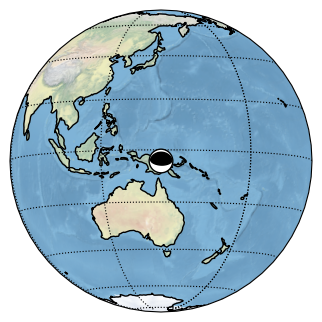

In [7]:
if event.preferred_focal_mechanism().moment_tensor:
    plot_event(event)
else:
    print("No moment tensor")

In [8]:
# building the data repository
if not(os.path.exists(event_id)):
    print(f">> Creating event directory {event_id}")
    os.mkdir(event_id)
os.chdir(event_id)

>> Creating event directory 2017-11-07_6.5


In [9]:
# getting and writting event info
# - all info in CMTSOLUTION format
# - the info needed for forward simulations in a source.dat file

R_EARTH_M = 6371000.
NM2CSEM   = 1e-20

quakeMLfile = f"{event_id}_event.xml"
sourceDatfile = f"{event_id}_source.dat"
print(f">> Writting event information in {sourceDatfile} and {quakeMLfile}")

tensor = event.preferred_focal_mechanism().moment_tensor.tensor
ev_lat = event.preferred_origin().latitude
ev_lon = event.preferred_origin().longitude
ev_dep = event.preferred_origin().depth
origin_time = event.preferred_origin().time

ev_colat = ev_lat + 90.
ev_radius = Rt - ev_dep

with open(sourceDatfile, 'w') as out:

    out.write(
        f"""# Position (radius(m), colatitude(°), longitude(°))
{ev_radius}
{ev_colat:8.4f}
{ev_lon:8.4f}
# Centroid Moment Tensor (10-20N.m) (m_rr,m_tt,m_pp,m_rt,m_rp,m_tp)
{tensor.m_rr * NM2CSEM:.5f}
{tensor.m_tt * NM2CSEM:.5f}
{tensor.m_pp * NM2CSEM:.5f}
{tensor.m_rt * NM2CSEM:.5f}
{tensor.m_rp * NM2CSEM:.5f}
{tensor.m_tp * NM2CSEM:.5f}
"""
    )

event.write(quakeMLfile, format="CMTSOLUTION")

>> Writting event information in 2017-11-07_6.5_source.dat and 2017-11-07_6.5_event.xml


***Get available stations***

In [9]:
# 1. get available stations then select

client_wf = Client("IRIS")

# time bounds
tmin_after_event = 500.
tmax_after_event = 2500.

# ----------------------------------
# configuration
# I use https://ds.iris.edu/wilber3 to determine these
dmin  = 85.0
dmax  = 125.0
azmin = -40.0
azmax = 40.0

# for fiji events to south america
lat_pivot = -30.
lon_pivot = -110.

# # indonesia events to Africa
lat_pivot = -10.
lon_pivot = 50.
dmin  = 70.0
dmax  = 120.0


# lat_pivot = 16.
# lon_pivot = -25.

# ----------------------------------

>> Refining station catalogue over azimuth with respect to the pivot point
>> distance-azimuth bounded domain
- centered upon (-6.7°lat,123.5°lon)
- distance in [70.0,120.0]°
- azimuth in  [-40.0,40.0]°, with respect to the pivot point (-10.0°lat,50.0°lon)


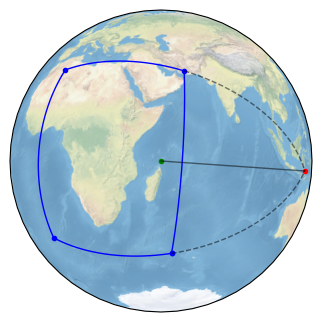

In [10]:
domain = DistanceAzimuthDomain(
        lat_center  = ev_lat,
        lon_center  = ev_lon,
        lat_pivot   = lat_pivot,
        lon_pivot   = lon_pivot,
        dmin        = dmin, 
        dmax        = dmax, 
        azmin       = azmin, 
        azmax       = azmax,
    )

print(f">> Refining station catalogue over azimuth with respect to the pivot point")
print(domain)
domain.plot()
plt.show();

In [11]:
print(">> Looking for available stations based upon :")
print(f"- time criteria : between {origin_time+tmin_after_event} and {origin_time+tmax_after_event}")
print(f"- distance criteria : between {dmin:.1f}° and {dmax:.1f}°")


networks_inventory = client_wf.get_stations(
    channel="BH*,HH*,LH*",
    starttime=origin_time+tmin_after_event,
    endtime=origin_time+tmax_after_event,
    latitude = ev_lat,
    longitude= ev_lon,
    minradius=dmin,
    maxradius=dmax
    )

nb_stations = sum([len(network) for network in networks_inventory])
print(f"Found {nb_stations} stations, over {len(networks_inventory)} networks.")

>> Looking for available stations based upon :
- time criteria : between 2020-08-21T04:18:11.930000Z and 2020-08-21T04:51:31.930000Z
- distance criteria : between 70.0° and 120.0°
Found 2341 stations, over 113 networks.


In [12]:
stations = MyInventory()

for nw in networks_inventory.networks:
    for st in nw._stations:
        if domain.is_in_domain(st._latitude, st._longitude):
            stations.append(MyStation(st.code, nw.code, st._latitude, st._longitude))
            
print(f"{stations.len()} respecting the azimuthal criteria.")

74 respecting the azimuthal criteria.


In [13]:
print(f"{stations.len()} stations found within the domain.")

175 stations found within the domain.


In [14]:
out_file = f"{event_id}_receivers.dat"
print(f">> Writting stations informations in {out_file}")
stations.write(out_file)

>> Writting stations informations in 2020-08-21_6.9_receivers.dat


In [13]:
# or get from file
stations = MyInventory()
# stations.read_fromDat("2020-08-21_6.9_receivers.dat.1")
stations.read_fromDat(out_file)
print(stations.len())

175


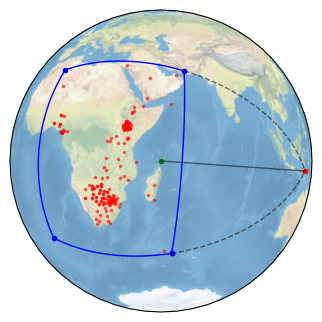

In [16]:
ax = domain.plot()
ax.scatter(stations.stations["lon"],stations.stations["lat"], transform = ccrs.PlateCarree(), marker=".", s = 10, color="r", alpha=0.5)
# plt.savefig("domain_search.png", dpi=500)

(1.8695559999999998, 58.791564, -50.23600305, 33.474944050000005)


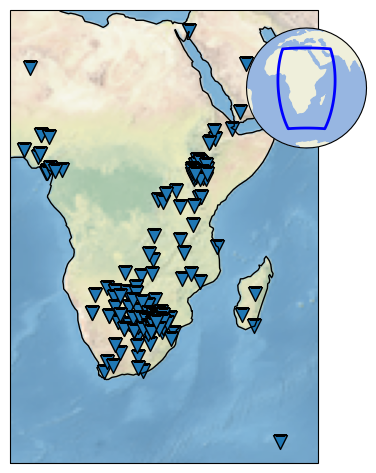

In [17]:
stations.plot()
plt.savefig("domain_search_potentially_avail_stations.png", dpi=500)

***Getting waveform data***

In [27]:
# Location priorities:
location_priorities = ("","00", "10", "01", "02", "20")

# Channel priorities
# channel_priorities1 = ("BH[ZNE12]", "LH[ZNE12]")
channel_priorities = ("HH*","BH*","LH*")

# Mass downloader over IRIS
# mdl = mass_downloader.MassDownloader( providers= ["IRIS"], configure_logging=False )
mdl = mass_downloader.MassDownloader( providers= ["IRIS"])

# Data directories
stations_dir = "stations"
wf_dir = "waveforms"

# Global domain (stations filtered to be inside directionnal domain)
global_domain = GlobalDomain()

# log to a file and not in stdout
logger = logging.getLogger("obspy.clients.fdsn.mass_downloader")

# remove console handler
logger.removeHandler(logger.handlers[0])

handler = logging.FileHandler('mass_downloader.log')
logger.addHandler(handler) 

In [28]:
# This loop might seem quite inefficient to you and it is. However, 
# the MassDownloader does not always download all the data requested if the
# list of stations is too large. Then, the user should re-run the MassDownloader
# a couple of times. As an alternative, we here run it for each station.

for nw_code,st_code in tqdm(zip(stations.stations["nw"],stations.stations["code"]), total=stations.len(),unit="station"):
    
    # print(f"Downloading data for station {nw_code:<2}.{st_code:<4} ({i/stations_in.len()*100:.0f}%).", end="\r")

    # set Restrictions
    restrictions = mass_downloader.Restrictions( 
                            starttime   = origin_time +tmin_after_event,
                            endtime     = origin_time +tmax_after_event,
                            location_priorities = location_priorities,
                            channel_priorities = channel_priorities,
                            # reject_channels_with_gaps = True,
                            reject_channels_with_gaps = False,
                            minimum_interstation_distance_in_m=1E2,
                            network = nw_code, station = st_code )

    # Start download
    mdl.download(
        global_domain, 
        restrictions, 
        mseed_storage = wf_dir, 
        stationxml_storage = stations_dir,
        print_report=False )

100%|██████████| 175/175 [00:14<00:00, 11.73station/s]


***Extracting station information***

In [23]:
# manuel 
# os.chdir("/home/gcl/BR/sbrisson/getting_observation_data_ULVZs/data.indonesia2africa/6.1_23-Aug-2016")
# os.chdir("/home/gcl/BR/sbrisson/data/6.2_18-Aug-2014")

In [29]:
# loading station data
stations2 = obspy.read_inventory("stations/*")
print(f"{len(stations2)} stations.")

33 stations.


In [24]:
stations2b = MyInventory()

for nw in stations2.networks:
    for st in nw._stations:
        if domain.is_in_domain(st._latitude, st._longitude):
            stations2b.append(MyStation(st.code, nw.code, st._latitude, st._longitude))

(2.994589, 58.737991, -50.23600305, 33.474944050000005)


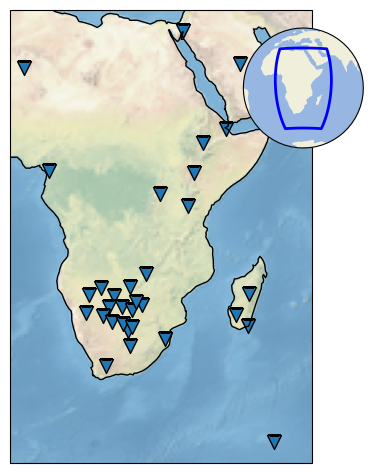

In [25]:
stations2b.plot()
plt.savefig("domain_search_effectively_avail_stations.png", dpi=500)

***processing waveform data***

In [26]:
# Reading waveform data into a stream obspy object
wf_dir = "waveforms"
st = Stream()
for waveform in os.listdir(wf_dir):
    st += read(os.path.join(wf_dir, waveform))

In [27]:
dist_list = []

# computing aditionnal metadata
for tr in st:
    
    st_coordinates = stations.get_coordinates(tr.id)
    st_lat = st_coordinates["latitude"]
    st_lon = st_coordinates["longitude"]
    
    tr.stats.coordinates = st_coordinates
    
    tr.stats.evla = ev_lat
    tr.stats.evlo = ev_lon
    tr.stats.evde = ev_dep/1000
    tr.stats.event_origin_time = origin_time
            
    _,b_az,_ = gps2dist_azimuth(st_lat, st_lon, ev_lat, ev_lon)
    dist = locations2degrees(st_lat, st_lon, ev_lat, ev_lon)
    
    tr.stats.back_azimuth = b_az # for rotation
    tr.stats.distance = dist
    
    dist_list.append(dist)

In [182]:
metadata = st[0].stats 
print(metadata.__dict__)

{'sampling_rate': 40.0, 'delta': 0.025, 'starttime': UTCDateTime(2014, 8, 18, 2, 32, 5, 350000), 'endtime': UTCDateTime(2014, 8, 18, 3, 32, 5, 350000), 'npts': 144001, 'calib': 1.0, 'network': 'TA', 'station': 'O53A', 'location': '', 'channel': 'BHN', 'mseed': AttribDict({'dataquality': 'M', 'number_of_records': 28, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 114688}), '_format': 'MSEED', 'coordinates': AttribDict({'latitude': 40.249298, 'longitude': -81.212898, 'elevation': 320.0, 'local_depth': 0.0}), 'evla': -6.71, 'evlo': 123.4649, 'evde': 624.0, 'event_origin_time': UTCDateTime(2020, 8, 21, 4, 9, 51, 930000), 'back_azimuth': 320.23747451081465, 'distance': 139.84278602981794}


In [29]:
print(f"Distances between {min(dist_list):.1f}° and {max(dist_list):.1f}°")

Distances between 125.5° and 144.8°


In [30]:
# interpolating and triming
st.interpolate(sampling_rate=5.0);

In [31]:
# rotating it
stations = set([tr.stats.station for tr in st])
st._trim_common_channels()

for station in stations:                       
    try:
        st.select(station=station).rotate('NE->RT')
    except ValueError:
        print(f"Couldn't rotate:\n{st.select(station=station)}")

In [32]:
# filtering it
ifmin = 20.0
ifmax = 10.0
st.filter('bandpass', freqmin=1/ifmin, freqmax=1/ifmax);

In [33]:
# saving it into serialized stream object (pickle format)
out_file =  f"{event_id}_{ifmax:.0f}s-{ifmin:.0f}s.pickle"
print(f">> Writting {out_file}")
st.write(out_file, format='PICKLE')

>> Writting 2020-08-21_6.9_10s-20s.pickle
